In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import gsw
from holteandtalley import HolteAndTalley
import os
from xmovie import Movie
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd

In [3]:
# much easier in netcdf format
#SST = pn.read_csv('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/L1_SST_data_ProcessedAUG30_2021.csv')

In [2]:
sst1 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/9bd1c68f26ce957283f2705a6f4d351b.nc')

In [3]:
sst2 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/9e231e194f77722b4ec78467a053baf6.nc')
sst3 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/79b6e789d3e145c094aae90f9600f8b0.nc')
sst4 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/a59ac185b8e5d9a34813fee58c0a9fdf.nc')
sst5 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/b0988ceaf10f0d2f3287c9d5c4c05cfd.nc')
sst6 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/d7a66efb0dd885bc6a6745e9921b6766.nc')
sst7 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST_2020JAN_2020APR.nc')

In [4]:
# Put all netcdfs together
sst = xr.merge([sst1,sst2,sst3,sst4,sst5,sst6,sst7])

In [8]:
# Look at the data
sst

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 61, time: 13913, zlev: 1)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01T12:00:00 ... 2020-04-01T12:00:00
  * zlev       (zlev) float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
Data variables:
    sst        (time, zlev, latitude, longitude) float32 18.29 19.3 ... nan nan

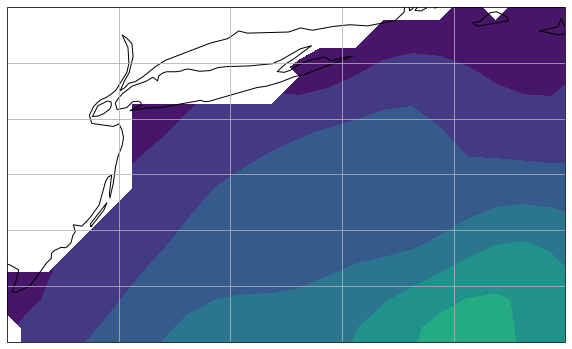

In [33]:
# See what it looks like
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(sst.longitude,sst.latitude,sst.sst[0,0,:,:],levels = np.arange(5,25,))

In [5]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')

In [6]:
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)

In [7]:
# Extract the polygon
nyb_shape = NYB.geometry[0]

In [12]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(sst.longitude,sst.latitude,test[7,:,:],levels = np.arange(0,25,1))
plt.contour(sst.longitude,sst.latitude,test[7,:,:],levels = [20,20],colors='k')
plt.colorbar(C)

NameError: name 'test' is not defined

In [8]:
# Test the groupby seasons function
seas = sst.groupby('time.season').mean('time')

In [9]:
seas # Note the seasons are given as 'DJF' 'JJA' 'MAM 'SON'

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 61, season: 4, zlev: 1)
Coordinates:
  * zlev       (zlev) float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sst        (season, zlev, latitude, longitude) float32 18.9 19.98 ... nan

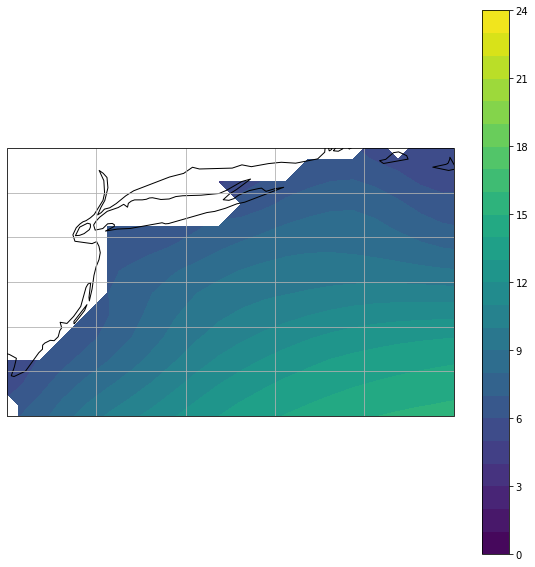

In [16]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(seas.longitude,seas.latitude,seas.sst[0,0,:,:],levels = np.arange(0,25,1))
plt.contour(sst.longitude,sst.latitude,seas.sst[0,0,:,:],levels = [20],colors='k')
plt.colorbar(C)

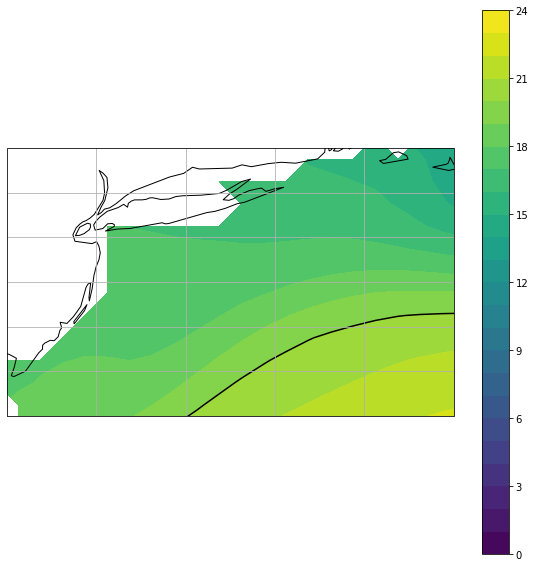

In [17]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(seas.longitude,seas.latitude,seas.sst[3,0,:,:],levels = np.arange(0,25,1))
plt.contour(sst.longitude,sst.latitude,seas.sst[3,0,:,:],levels = [20],colors='k')
plt.colorbar(C)

In [10]:
# Prep years to loop through and group by season each time
unique_years = np.unique(pn.to_datetime(sst.time.values).year)
years = pn.to_datetime(sst.time.values).year

In [11]:
empty = np.empty([154,len(sst.latitude),len(sst.longitude)])
empty[:,:,:] = np.nan
k=0
for i in unique_years[:-1]:
    index = np.where(years == i)
    sst_subset = sst.sst[index[0],0,:,:]
    sst_subset_seas = sst_subset.groupby('time.season').mean('time')
    empty[k:k+4,:,:] = sst_subset_seas
    k=k+4
index = np.where(years == 2020)
sst_subset = sst.sst[index[0],0,:,:]
sst_subset_seas = sst_subset.groupby('time.season').mean('time')
empty[k:k+2,:,:] = sst_subset_seas
sst_seas = empty

In [12]:
i=1983
index = np.where(years == i)
sst_subset = sst.sst[index[0],0,:,:]
sst_subset_seas = sst_subset.groupby('time.season').mean('time')
sst_subset_seas.season

<xarray.DataArray 'season' (season: 4)>
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
    zlev     float32 0.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [13]:
years

Int64Index([1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', length=13913)

In [14]:
quarterly_dates = pn.date_range('1982-01-01','2020-06-01', freq = 'BQ-FEB')

In [15]:
def inNYB(longitude, latitude, time, sst, shape):
    X = longitude
    Y = latitude
    y, x = np.meshgrid(Y,X)
    empty = np.empty([len(time), len(latitude), len(longitude)])
    empty[:,:,:] = np.nan
    for i in range(len(longitude)):
        for j in range(len(latitude)):
            if Point(x[i,j], y[i,j]).within(shape) == True:
                empty[:,j,i] = sst[:,i,j]
    return empty

In [16]:
test_seas=inNYB(sst.longitude,sst.latitude,quarterly_dates,sst_seas,nyb_shape)

In [17]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(sst.longitude,sst.latitude,test_seas[7,:,:],levels = np.arange(0,25,1))
plt.contour(sst.longitude,sst.latitude,test_seas[7,:,:],levels = [20],colors='k')
plt.colorbar(C)

In [18]:
plt.imshow(test_seas[0,:,:])


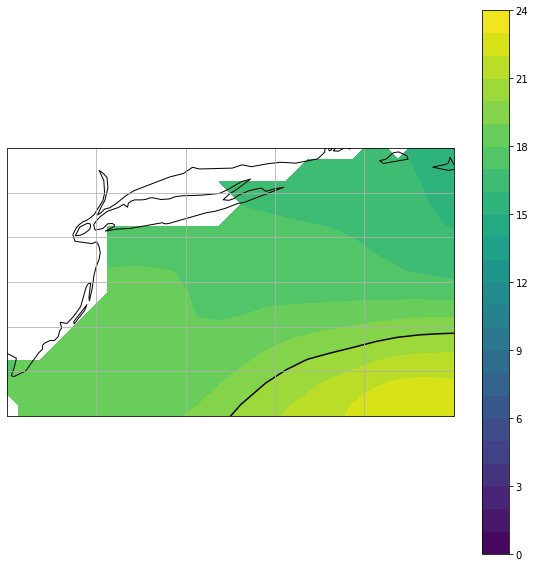

In [21]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(sst.longitude,sst.latitude,sst_seas[7,:,:],levels = np.arange(0,25,1))
plt.contour(sst.longitude,sst.latitude,sst_seas[7,:,:],levels = [20],colors='k')
plt.colorbar(C)

In [22]:
DJF = np.arange(0,154,4)
JJA = np.arange(1,154,4)
MAM = np.arange(2,154,4)
SON = np.arange(3,154,4)
#yes this seems weird but apparently groupby groups the seasons winter summer spring fall

In [23]:
quarterly_dates.year

Int64Index([1982, 1982, 1982, 1982, 1983, 1983, 1983, 1983, 1984, 1984,
            ...
            2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2020, 2020],
           dtype='int64', length=154)

In [24]:
NYB

,ID,area_m,dummy,Shape_Leng,Shape_Area,Area_SqMi,geometry
0,0.0,43471.799751,0,910713.7766,4.347178e+10,16784.548944,"POLYGON ((-71.66879 41.05893, -71.64509 40.949..."


In [25]:
import cartopy.io.shapereader as shpreader
import cartopy
reader = shpreader.Reader("/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp")
countries = reader.records()
country = next(countries)
#kenya = [country for country in reader.records() if country.attributes["NAME_LONG"] == "Kenya"][0]
print (type(country.attributes))
print (sorted(country.attributes.keys()))
shape_feature = ShapelyFeature([country.geometry], ccrs.PlateCarree(), facecolor="lime", edgecolor='black', lw=1)

<class 'dict'>
['Area_SqMi', 'ID', 'Shape_Area', 'Shape_Leng', 'area_m', 'dummy']


NameError: name 'ShapelyFeature' is not defined

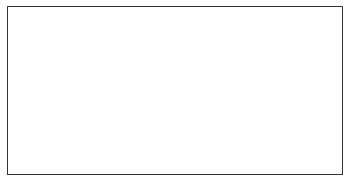

In [26]:
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature


#There is currently no ShapefileFeature class (though that would be easy enough to create, and would probably make a lot of sense) so if you really want to use the feature interface then there is a hoop to jump through:

#import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#from cartopy.io.shapereader import Reader
#from cartopy.feature import ShapelyFeature

fname = "/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp"

ax = plt.axes(projection=ccrs.PlateCarree())
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='r',edgecolor = 'k'
                              )
ax.add_feature(shape_feature)
plt.show()


In [27]:
sst.longitude[:20]

<xarray.DataArray 'longitude' (longitude: 20)>
array([-79.875, -79.625, -79.375, -79.125, -78.875, -78.625, -78.375, -78.125,
       -77.875, -77.625, -77.375, -77.125, -76.875, -76.625, -76.375, -76.125,
       -75.875, -75.625, -75.375, -75.125], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -75.62 -75.38 -75.12
Attributes:
    _CoordinateAxisType:  Lon
    actual_range:         [-79.875 -64.875]
    axis:                 X
    grids:                Uniform grid from 0.125 to 359.875 by 0.25
    ioos_category:        Location
    long_name:            Longitude
    standard_name:        longitude
    units:                degrees_east

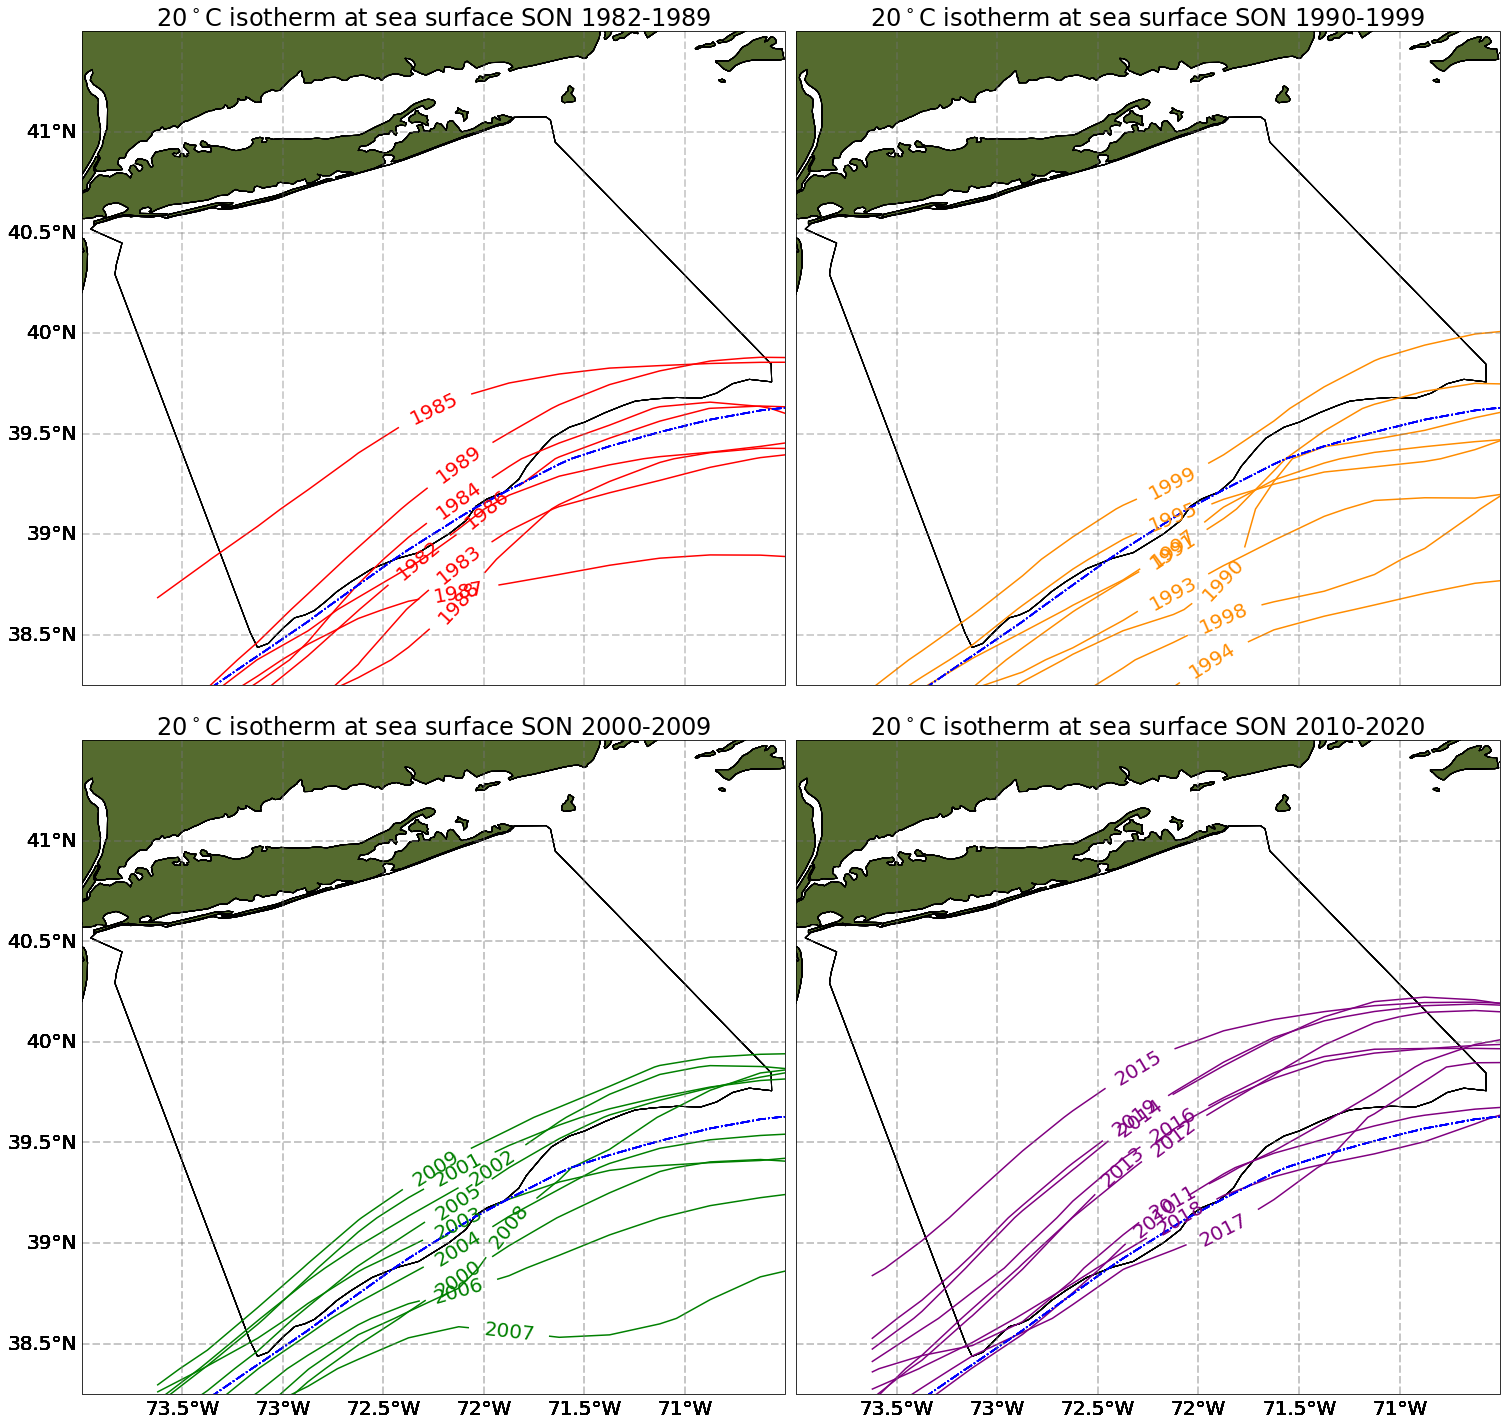

In [34]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(len(SON)):
    if np.nanmax(test_seas[SON[i],:,:]) >= 20:
        text = np.arange(1982,2020,1)
        text2 = str(text[i])
        if text[i]<1990:
            extent = [286,289.5,38.25,41.5]
            gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            ax[0,0].set_extent(extent)
            ax[0,0].coastlines(resolution='10m')
            CS = ax[0,0].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='r',transform=ccrs.PlateCarree())
            ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[0,0].clabel(CS, fontsize=20, inline=1, fmt=text2)
            #ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
            ax[0,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[0,0].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
            ax[0,0].set_title('20$^\circ$C isotherm at sea surface SON 1982-1989', fontsize = 24)
        if text[i]>=1990 and text[i]<2000:
            extent = [286,289.5,38.25,41.5]
            ax[0,1].set_extent(extent)
            gl = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            gl.ylabels_left = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            ax[0,1].coastlines(resolution='10m')
            CS = ax[0,1].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='darkorange')
            ax[0,1].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[0,1].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[0,1].add_geometries(NYB.geometry,
                    ccrs.PlateCarree(),
                    facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[0,1].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
            ax[0,1].set_title('20$^\circ$C isotherm at sea surface SON 1990-1999', fontsize = 24)
        if text[i]>=2000 and text[i]<2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,0].set_extent(extent)
            gl = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = True
            gl.ylabels_right = False
            gl.ylabels_left = True
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            gl.xlabel_style = {'size': 20, 'color': 'k'}
            ax[1,0].coastlines(resolution='10m')
            CS = ax[1,0].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='g')
            ax[1,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[1,0].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[1,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[1,0].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
            ax[1,0].set_title('20$^\circ$C isotherm at sea surface SON 2000-2009', fontsize = 24)
        if text[i]>=2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,1].set_extent(extent)
            gl = ax[1,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = True
            gl.ylabels_right = False
            gl.ylabels_left = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            gl.xlabel_style = {'size': 20, 'color': 'k'}
            ax[1,1].coastlines(resolution='10m')
            CS = ax[1,1].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='purple')
            ax[1,1].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[1,1].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[1,1].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[1,1].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
            ax[1,1].set_title('20$^\circ$C isotherm at sea surface SON 2010-2020', fontsize = 24)

plt.tight_layout()

In [ ]:
        if text[i]<1990:
            extent = [286,289.5,38.25,41.5]
            gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            ax[0,0].set_extent(extent)
            ax[0,0].coastlines(resolution='10m')
            CS = ax[0,0].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='r',transform=ccrs.PlateCarree())
            ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[0,0].clabel(CS, fontsize=20, inline=1, fmt=text2)
            #ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
            ax[0,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[0,0].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
            ax[0,0].set_title('20C isotherm at sea surface SON 1982-1989', fontsize = 24)

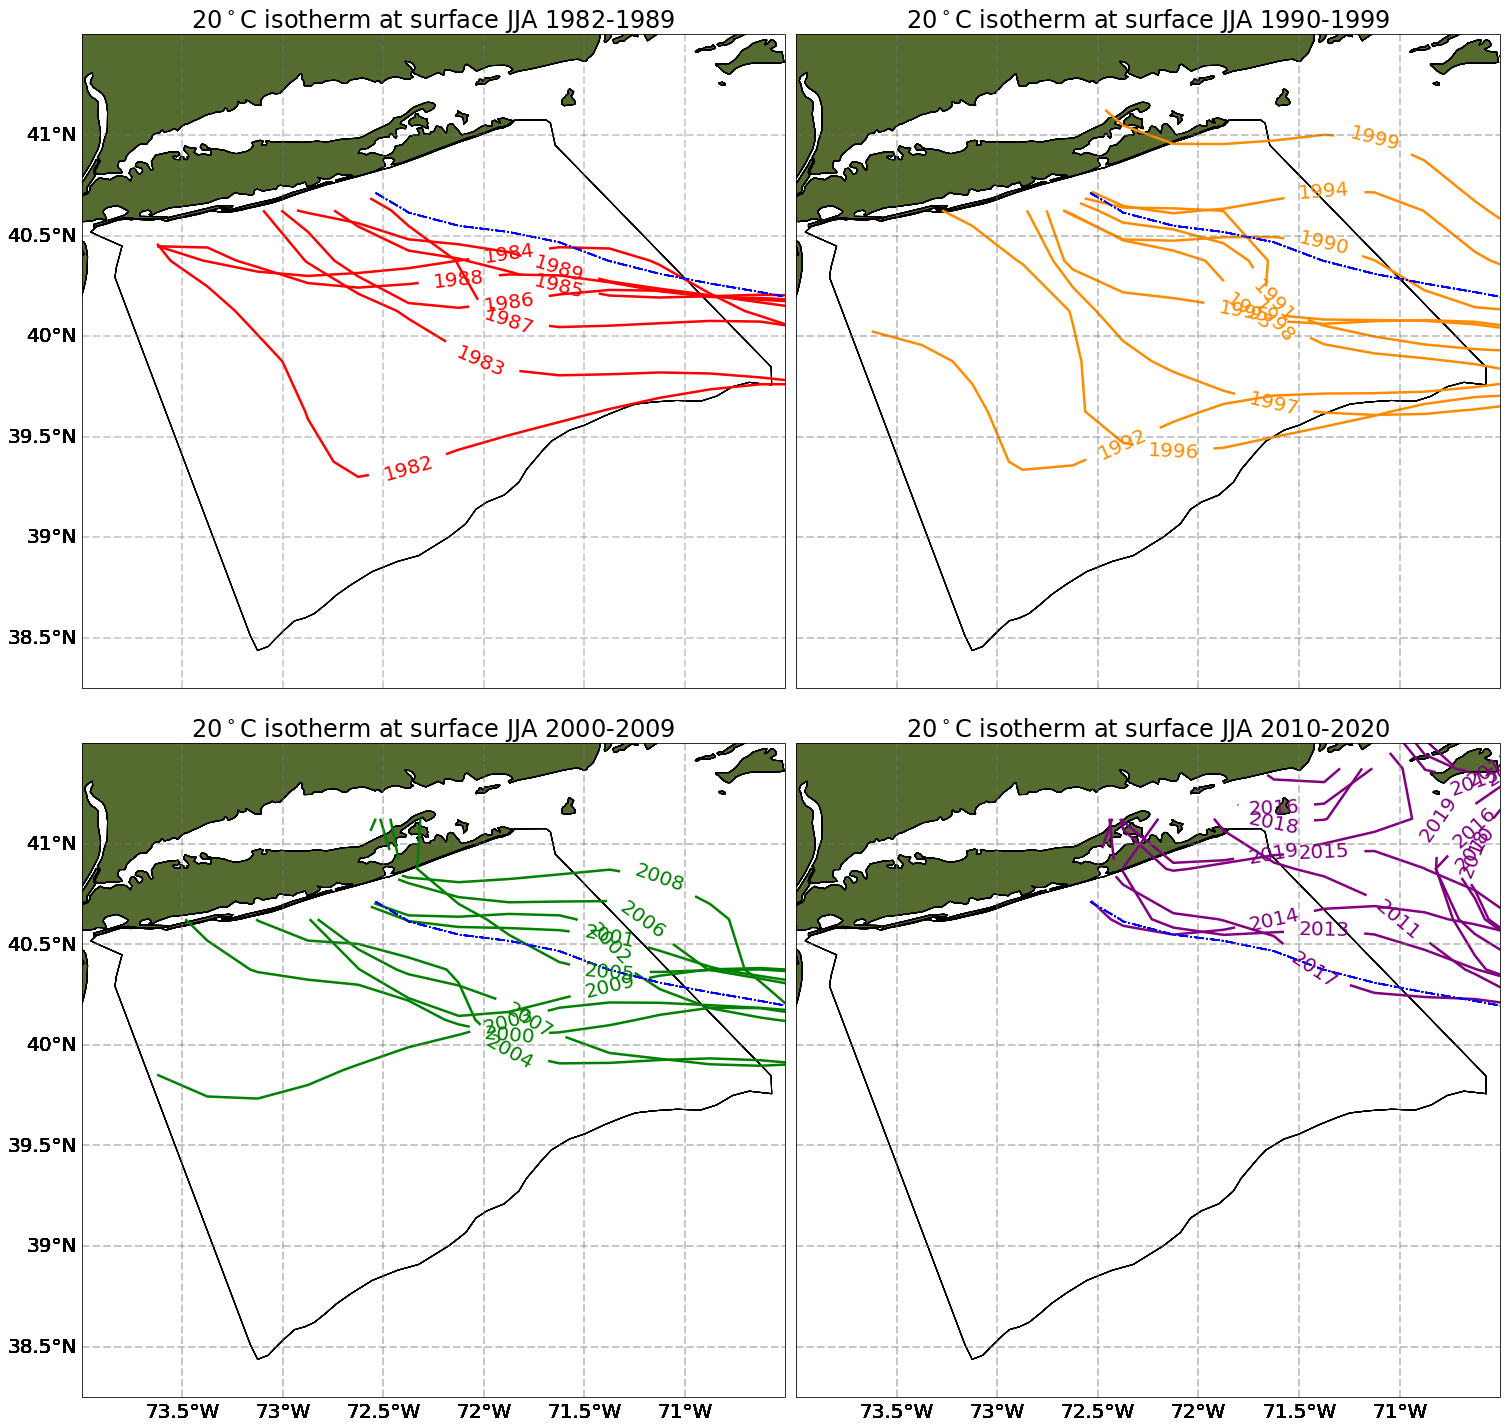

In [29]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(len(JJA)-1):
    if np.nanmax(sst_seas[JJA[i],:,:]) >= 20:
        text = np.arange(1982,2020,1)
        text2 = str(text[i])
        if text[i]<1990:
            extent = [286,289.5,38.25,41.5]
            gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            ax[0,0].set_extent(extent)
            ax[0,0].coastlines(resolution='10m')
            CS = ax[0,0].contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='r',linewidths = 2.5,transform=ccrs.PlateCarree())
            ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[1,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[0,0].clabel(CS, fontsize=20, inline=1, fmt=text2)
            #ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
            ax[0,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[0,0].set_title('20$^\circ$C isotherm at surface JJA 1982-1989', fontsize = 24)
            ax[0,0].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
        if text[i]>=1990 and text[i]<2000:
            extent = [286,289.5,38.25,41.5]
            ax[0,1].set_extent(extent)
            gl = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            gl.ylabels_left = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            ax[0,1].coastlines(resolution='10m')
            CS = ax[0,1].contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='darkorange',linewidths = 2.5)
            ax[0,1].contour(seas.longitude[25:40],seas.latitude, seas.sst[1,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[0,1].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[0,1].add_geometries(NYB.geometry,
                    ccrs.PlateCarree(),
                    facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[0,1].set_title('20$^\circ$C isotherm at surface JJA 1990-1999', fontsize = 24)
            ax[0,1].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
        if text[i]>=2000 and text[i]<2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,0].set_extent(extent)
            gl = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = True
            gl.ylabels_right = False
            gl.ylabels_left = True
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            gl.xlabel_style = {'size': 20, 'color': 'k'}
            ax[1,0].coastlines(resolution='10m')
            CS = ax[1,0].contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='g',linewidths = 2.5)
            ax[1,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[1,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[1,0].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[1,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[1,0].set_title('20$^\circ$C isotherm at surface JJA 2000-2009', fontsize = 24)
            ax[1,0].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
        if text[i]>=2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,1].set_extent(extent)
            gl = ax[1,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = True
            gl.ylabels_right = False
            gl.ylabels_left = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            gl.xlabel_style = {'size': 20, 'color': 'k'}
            ax[1,1].coastlines(resolution='10m')
            CS = ax[1,1].contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='purple',linewidths = 2.5)
            ax[1,1].contour(seas.longitude[25:40],seas.latitude, seas.sst[1,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[1,1].clabel(CS, fontsize=20,inline=1, fmt=text2)
            ax[1,1].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[1,1].set_title('20$^\circ$C isotherm at surface JJA 2010-2020', fontsize = 24)
            ax[1,1].add_feature(cartopy.feature.LAND, color = 'darkolivegreen')

plt.tight_layout()

NameError: name 'son_NYB' is not defined

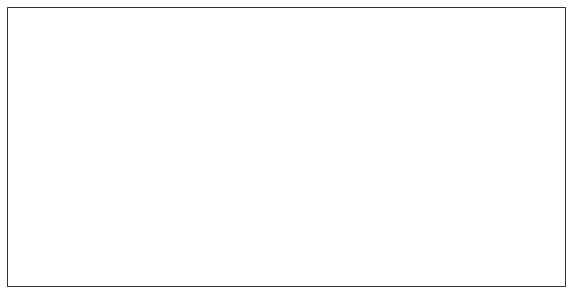

In [30]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [10,10],subplot_kw={'projection': ccrs.PlateCarree()})
ax.contourf(sst.longitude,sst.latitude,son_NYB[0,:,:],levels = np.arange(15,25,1))
ax.coastlines(resolution='10m')
ax.add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')

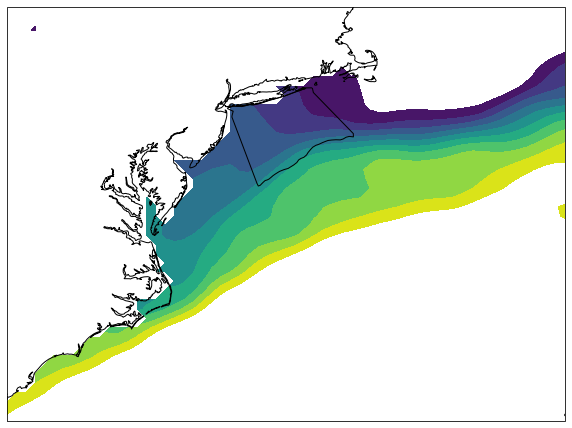

In [114]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [10,10],subplot_kw={'projection': ccrs.PlateCarree()})
ax.contourf(sst.longitude,sst.latitude,sst_seas[SON][0],levels = np.arange(15,25,1))
ax.coastlines(resolution='10m')
ax.add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')

In [95]:
sst.latitude

<xarray.DataArray 'latitude' (latitude: 57)>
array([32.125, 32.375, 32.625, 32.875, 33.125, 33.375, 33.625, 33.875, 34.125,
       34.375, 34.625, 34.875, 35.125, 35.375, 35.625, 35.875, 36.125, 36.375,
       36.625, 36.875, 37.125, 37.375, 37.625, 37.875, 38.125, 38.375, 38.625,
       38.875, 39.125, 39.375, 39.625, 39.875, 40.125, 40.375, 40.625, 40.875,
       41.125, 41.375, 41.625, 41.875, 42.125, 42.375, 42.625, 42.875, 43.125,
       43.375, 43.625, 43.875, 44.125, 44.375, 44.625, 44.875, 45.125, 45.375,
       45.625, 45.875, 46.125], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
Attributes:
    _CoordinateAxisType:  Lat
    actual_range:         [32.125 46.125]
    axis:                 Y
    grids:                Uniform grid from -89.875 to 89.875 by 0.25
    ioos_category:        Location
    long_name:            Latitude
    standard_name:        latitude
    units:                degrees_north

In [39]:
sst

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 61, time: 13913, zlev: 1)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01T12:00:00 ... 2020-04-01T12:00:00
  * zlev       (zlev) float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
Data variables:
    sst        (time, zlev, latitude, longitude) float32 18.29 19.3 ... nan nan

In [178]:
#sst.time
time_SON = np.arange(1982,2020
          ,1)
time_JJA = np.arange(1982,2021
          ,1)

In [179]:
son_NYB = inNYB(sst.longitude,sst.latitude,time_SON,sst_seas[SON],nyb_shape)
np.shape(son_NYB)

jja_NYB = inNYB(sst.longitude,sst.latitude,time_JJA,sst_seas[JJA],nyb_shape)
np.shape(jja_NYB)

(39, 57, 61)

<ipython-input-149-906b8fb4f5f1>:2: UserWarning: No contour levels were found within the data range.
  plt.contour(sst.longitude[25:40],sst.latitude[20:40],son_NYB[0,20:40,25:40],levels = [20])


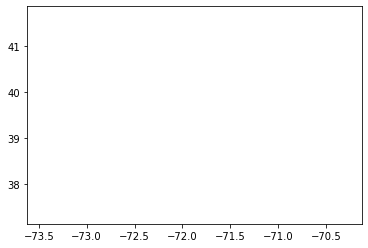

In [149]:
#plt.contour(sst.longitude[25:40],sst.latitude[20:40],son_NYB[30,20:40,25:40],levels = [20])
plt.contour(sst.longitude[25:40],sst.latitude[20:40],son_NYB[0,20:40,25:40],levels = [20])
#line = C.allsegs[0][0]
#print(line)

In [130]:
C.allsegs

[[array([[-71.625,  40.875]])]]

In [204]:
max_lat_SON = np.empty(38)
lat_lon_SON = np.empty(38)
for i in range(38):
    line=[]
    C = ax.contour(sst.longitude[25:40],sst.latitude,son_NYB[i,:,25:40],levels = [20])
    line = C.allsegs[0][0]
    if len(line) == 1:
        max_lat_SON[i] = np.nan
        lat_lon_SON[i] = np.nan
    else:
        max_lat_SON[i] = np.max(line)
        lat_lon_SON[i] = line[np.where(line[:,0]==np.min(line)),0][0][0]

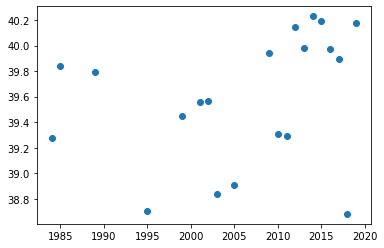

In [174]:
plt.scatter(time_SON,max_lat_SON)

In [199]:
min_lon_JJA = np.empty(39)
lat_lon_JJA = np.empty(39)
for i in range(39):
    line=[]
    C = ax.contour(sst.longitude[25:40],sst.latitude,jja_NYB[i,:,25:40],levels = [20])
    line = C.allsegs[0][0]
    if len(line) == 1:
        min_lon_JJA[i] = np.nan
        lat_lon_JJA[i] = np.nan
    else:
        min_lon_JJA[i] = np.min(line)
        lat_lon_JJA[i] = line[np.where(line[:,0]==np.min(line)),1][0][0]

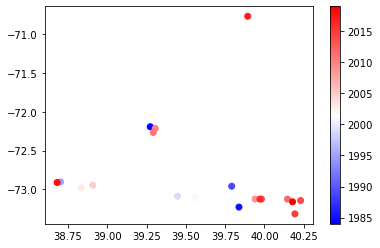

In [207]:
plt.scatter(max_lat_SON,lat_lon_SON,c = time_SON,cmap = 'bwr')
plt.colorbar()

In [211]:
#max_lat_SON = np.append(max_lat_SON,np.nan)
#lat_lon_SON = np.append(lat_lon_SON, np.nan)

In [212]:
lat_lon_SON

array([         nan,          nan, -72.19239189, -73.22828453,
                nan,          nan,          nan, -72.95922069,
                nan,          nan,          nan,          nan,
                nan, -72.90302354,          nan,          nan,
                nan, -73.08889287,          nan, -73.09125291,
       -73.11086578, -72.97702191,          nan, -72.94556382,
                nan,          nan,          nan, -73.125     ,
       -72.21441382, -72.26572559, -73.125     , -73.125     ,
       -73.14350911, -73.31653272, -73.125     , -70.76726639,
       -72.91141172, -73.16048341,          nan])

In [219]:
d = {'SON_lat': max_lat_SON,'SON_lon': lat_lon_SON, 'JJA_lat': lat_lon_JJA, 'JJA_lon' : min_lon_JJA}
Iso20 = pn.DataFrame(data = d, index = time_JJA)
Iso20.to_csv('/Users/nyelab/Desktop/NYB Indicators/FInal_Timeseries/Iso20_Jan_11_2022.csv')

<ipython-input-147-430a75624e5d>:2: UserWarning: No contour levels were found within the data range.
  plt.contour(sst.longitude[25:40],sst.latitude[20:40],son_NYB[0,20:40,25:40],levels = [20])


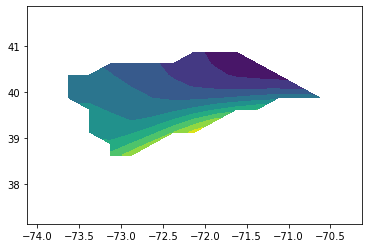

In [147]:
plt.contourf(sst.longitude[23:40],sst.latitude[20:40],son_NYB[0,20:40,23:40])
plt.contour(sst.longitude[25:40],sst.latitude[20:40],son_NYB[0,20:40,25:40],levels = [20])

In [84]:
sst

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 61, time: 13913, zlev: 1)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01T12:00:00 ... 2020-04-01T12:00:00
  * zlev       (zlev) float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
Data variables:
    sst        (time, zlev, latitude, longitude) float32 18.29 19.3 ... nan nan

In [32]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(len(JJA)):
    if np.nanmax(test_seas[JJA[i],:,:]) >= 20:
        text = np.arange(1982,2020,1)
        text2 = str(text[i])
        if text[i]<1990:
            extent = [286,288.5,38.5,41.5]
            ax[0,0].set_extent(extent)
            ax[0,0].gridlines()
            ax[0,0].coastlines(resolution='50m')
            CS = ax[0,0].contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='r',transform=ccrs.PlateCarree())
            ax[0,0].clabel(CS, fontsize=12, inline=1, fmt=text2)
        if text[i]>=1990 and text[i]<2000:
            extent = [286,288.5,38.5,41.5]
            ax[0,1].set_extent(extent)
            ax[0,1].gridlines()
            ax[0,1].coastlines(resolution='50m')
            CS = ax[0,1].contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='y',transform=ccrs.PlateCarree())
            ax[0,1].clabel(CS, fontsize=12, inline=1, fmt=text2)
        if text[i]>=2000 and text[i]<2010:
            extent = [286,288.5,38.5,41.5]
            ax[1,0].set_extent(extent)
            ax[1,0].gridlines()
            ax[1,0].coastlines(resolution='50m')
            CS = ax[1,0].contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='b',transform=ccrs.PlateCarree())
            ax[1,0].clabel(CS, fontsize=12, inline=1, fmt=text2)
        if text[i]>=2010:
            extent = [286,288.5,38.5,41.5]
            ax[1,1].set_extent(extent)
            ax[1,1].gridlines()
            ax[1,1].coastlines(resolution='50m')
            CS = ax[1,1].contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='k',transform=ccrs.PlateCarree())
            ax[1,1].clabel(CS, fontsize=12, inline=1, fmt=text2)

plt.tight_layout()

In [34]:
DJF = np.arange(0,154,4)
JJA = np.arange(1,154,4)
MAM = np.arange(2,154,4)
SON = np.arange(3,154,4)
#yes this seems weird but apparently groupby groups the seasons winter summer spring fall

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 61, time: 13913, zlev: 1)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01T12:00:00 ... 2020-04-01T12:00:00
  * zlev       (zlev) float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
Data variables:
    sst        (time, zlev, latitude, longitude) float32 18.29 19.3 ... nan nan

In [120]:
# look at only sst data within the NYB
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)
# Extract the polygon
nyb_shape = NYB.geometry[0]
# Function that checks if the points are within the NYB (variable without depth - FOR LOBSTER THERMAL HABITAT)
def inNYB(longitude, latitude, time, var, shape):
    X = longitude
    Y = latitude
    x, y = np.meshgrid(X, Y)
    empty = np.empty([len(time), len(latitude), len(longitude)])
    empty[:,:,:] = np.nan
    for i in range(len(latitude)):
        for j in range(len(longitude)):
            if Point(x[i,j], y[i,j]).within(shape) == True:
                empty[:,i,j] = var[:,i,j]
    return empty
# seasonal mean
# interpolate to 20C

In [116]:
np.shape(x)

(57, 61)

In [118]:
np.shape(Y)

(57,)

In [119]:
sst

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 61, time: 13913, zlev: 1)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01T12:00:00 ... 2020-04-01T12:00:00
  * zlev       (zlev) float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
Data variables:
    sst        (time, zlev, latitude, longitude) float32 18.29 19.3 ... nan nan

In [34]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(len(SON)):
    if np.nanmax(sst_seas[MAM[i],:,:]) >= 20:
        text = np.arange(1982,2020,1)
        text2 = str(text[i])
        if text[i]<1990:
            extent = [286,289.5,38.25,41.5]
            ax[0,0].set_extent(extent)
            ax[0,0].gridlines()
            ax[0,0].coastlines(resolution='50m')
            CS = ax[0,0].contour(sst.longitude,sst.latitude,sst_seas[MAM[i],:,:],levels = [20],colors='r')
            ax[0,0].clabel(CS, fontsize=12, inline=1, fmt=text2)
            ax[0,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
        if text[i]>=1990 and text[i]<2000:
            extent = [286,289.5,38.25,41.5]
            ax[0,1].set_extent(extent)
            ax[0,1].gridlines()
            ax[0,1].coastlines(resolution='50m')
            CS = ax[0,1].contour(sst.longitude,sst.latitude,sst_seas[MAM[i],:,:],levels = [20],colors='y')
            ax[0,1].clabel(CS, fontsize=12, inline=1, fmt=text2)
            ax[0,1].add_geometries(NYB.geometry,
                    ccrs.PlateCarree(),
                    facecolor='none', edgecolor = 'k')#hatch='xxxx')
        if text[i]>=2000 and text[i]<2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,0].set_extent(extent)
            ax[1,0].gridlines()
            ax[1,0].coastlines(resolution='50m')
            CS = ax[1,0].contour(sst.longitude,sst.latitude,sst_seas[MAM[i],:,:],levels = [20],colors='b')
            ax[1,0].clabel(CS, fontsize=12, inline=1, fmt=text2)
            ax[1,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
        if text[i]>=2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,1].set_extent(extent)
            ax[1,1].gridlines()
            ax[1,1].coastlines(resolution='50m')
            CS = ax[1,1].contour(sst.longitude,sst.latitude,sst_seas[MAM[i],:,:],levels = [20],colors='k')
            ax[1,1].clabel(CS, fontsize=12, inline=1, fmt=text2)
            ax[1,1].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')

plt.tight_layout()

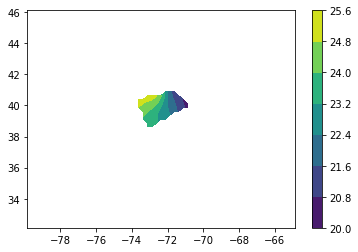

In [270]:
np.nanmax(test_seas[JJA[i],:,:]) >= 20
c = plt.contourf(sst.longitude,sst.latitude,test_seas[JJA[i],:,:])
plt.colorbar(c)

In [247]:
i=0
text = np.arange(1982,2020,1)
text2 = str(text[i])
text[i]>=1990 and text[i]<2000


False

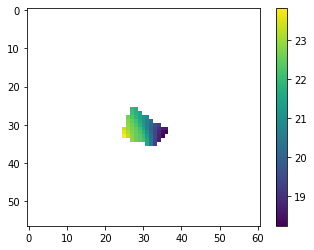

In [200]:
c = plt.imshow(test_seas[MAM[4],:,:])
plt.colorbar(c)

In [170]:
    X = sst.longitude
    Y = sst.latitude
    y, x = np.meshgrid(Y,X)
    empty = np.empty([len(quarterly_dates), len(sst.latitude), len(sst.longitude)])
    empty[:,:,:] = np.nan

In [171]:
np.shape(empty)

(154, 57, 61)

In [162]:
len(quarterly_dates)

154

In [164]:
np.shape(sst_seas)

(3479, 57, 61)

In [165]:
154/4

38.5

In [166]:
2020-1982

38